In [143]:
##Regression
#Purpose is to predict the values of continuous outputs like prices or probabilities

In [144]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [145]:
!pip install -q seaborn

In [146]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


In [147]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [148]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',
                'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, 
                          na_values = "?", comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [149]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [150]:
dataset = dataset.dropna()

In [151]:
origin = dataset.pop('Origin')

In [152]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japen'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japen
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [153]:
##Divide dataset into trainset and testset
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

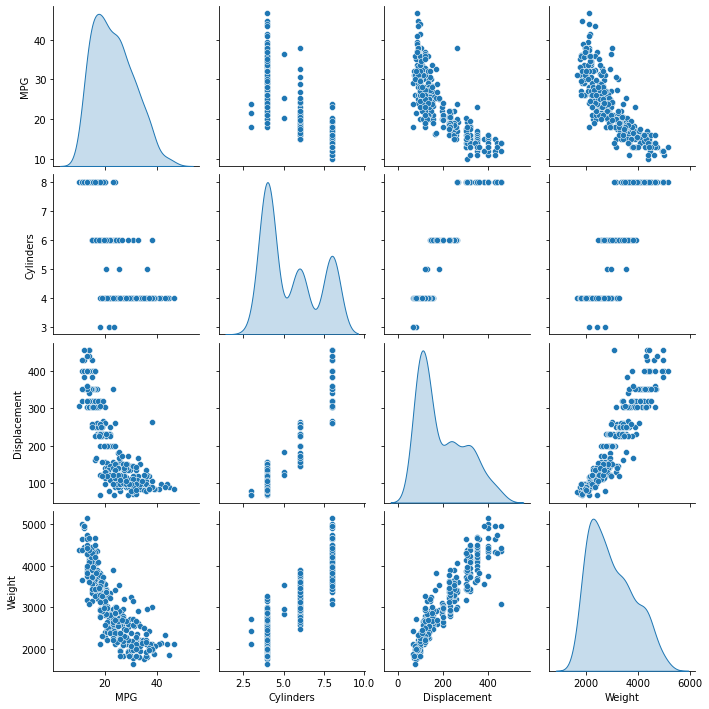

In [154]:
##Investigate data
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]],
              diag_kind='kde')

In [155]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japen,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [156]:
##Seperate target value or "label" from features
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [157]:
##Data Normalization
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [158]:
##Make a model with two densely connected layers
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [159]:
model = build_model()

In [160]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                640       
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [161]:
##Conduct the model once.
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.14729314],
       [-0.32831675],
       [-0.30730796],
       [-0.43040258],
       [-0.49671364],
       [-0.18658826],
       [-0.5140222 ],
       [-0.77275413],
       [ 0.07002913],
       [-0.7138574 ]], dtype=float32)

In [162]:
##Train the model with 1,000 epoch
##The object of history records train accuracy and validation accuracy
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    '''Express the process of training
       by printing a dot whenever every epoch ends up'''
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [163]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.715281,1.089761,2.715281,9.229286,2.405942,9.229286,995
996,2.689420,1.045641,2.689420,9.124330,2.414346,9.124330,996
997,2.873725,1.092745,2.873725,9.647226,2.506222,9.647226,997
998,2.521879,1.002325,2.521879,9.363469,2.470100,9.363469,998
999,2.691875,1.068690,2.691875,9.046138,2.407351,9.046138,999


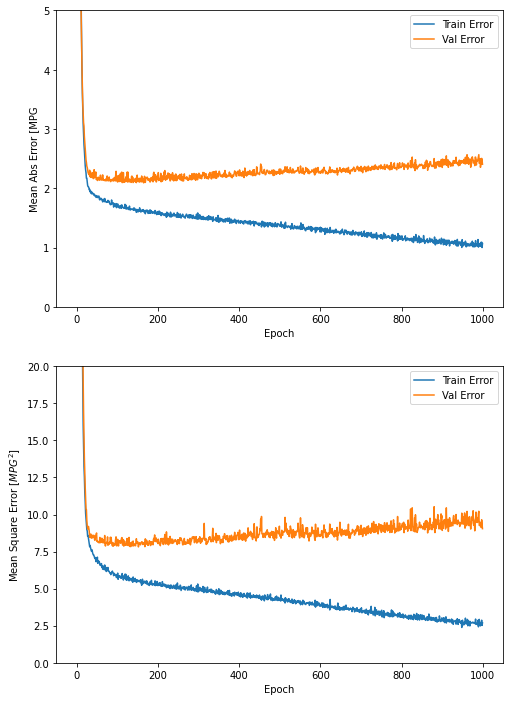

In [164]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label='Val Error')
  
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label='Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)  


........................................................

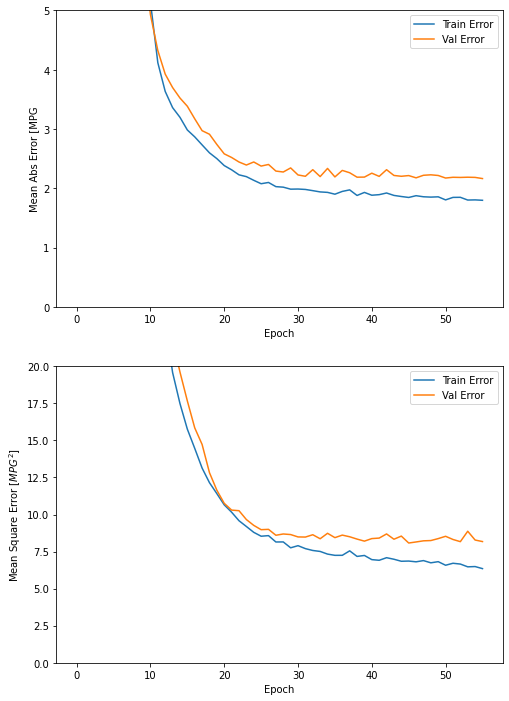

In [166]:
##The result above looks that the model was not improved in spite of progressing many epochs
#By using the method 'model.fit', make it stop automatically if the validation score is not better
#Use 'EarlyStopping'
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_check = keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/PRACTICE/Regression_best_model.h5',
                                              monitor='val_loss',
                                              save_best_only=True)

history = model.fit(
    normed_train_data, train_labels, 
    epochs=EPOCHS,
    batch_size = 32,
    validation_split = 0.2, 
    verbose = 0, 
    callbacks=[early_stop, model_check, PrintDot()])

plot_history(history)

In [169]:
##Confirm the performance of the model in testset where data does not be used during the training phase
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Mean Absolut Error:{:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.4272 - mae: 1.9913 - mse: 6.4272 - 24ms/epoch - 8ms/step
Mean Absolut Error: 1.99 MPG


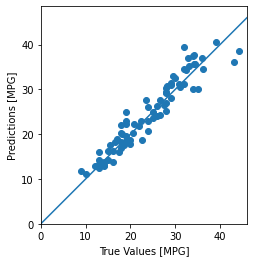

In [180]:
##Prediction
#Finally, anticipate the MPG value employing the samples in the testset
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

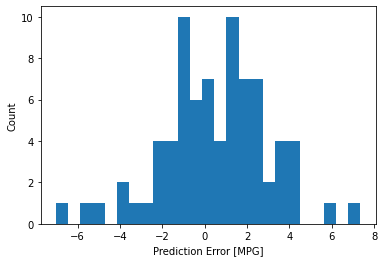

In [185]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [ ]:
'''Summary
 1. MSE usually used in the projects of regression
 2. Criteria from regression is also different from that of classification
 3. Have to adjust independently the scale of each feature if they have several ranges
 4. Choose the size of a network that has small counts of densely connected layers if training data is not enough, for avoiding overfitting
 5. Good solution is using 'Early stopping' for averting overfitting'''